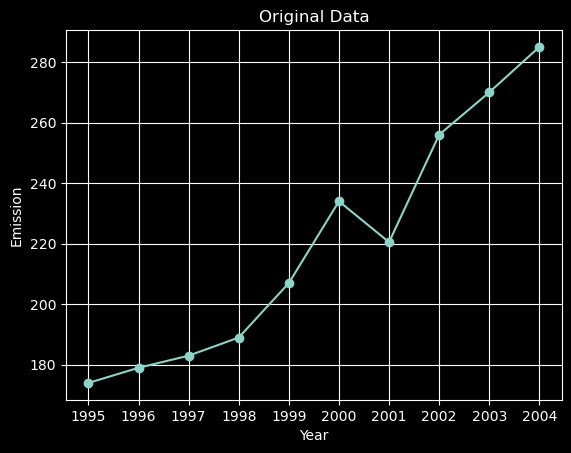

Data length: 10


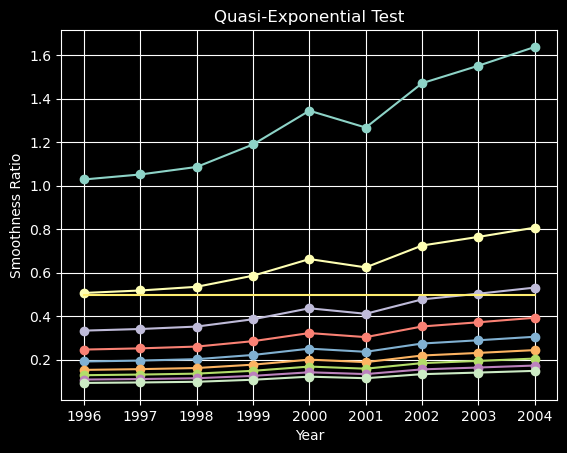

Smooth ratio <0.5: 677.8%
Excluding first two: 671.4%
Training data: [174.  179.  183.  189.  207.  234.  220.5]
Test data: [256. 270. 285.]


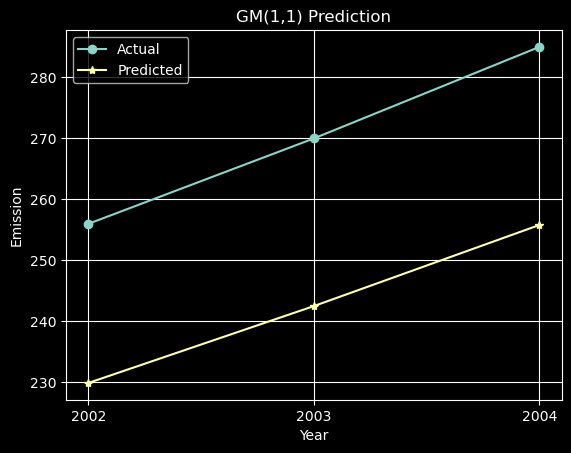


Fitting results:
1995: 174.0
1996: 162.4
1997: 172.8
1998: 183.9
1999: 195.8
2000: 208.4
2001: 221.8
2002: 236.1
2003: 251.3
2004: 267.5

Predictions:
2005: 284.7
2006: 303.0
2007: 322.5
2008: 343.3
2009: 365.4
2010: 388.9
2011: 414.0
2012: 440.6
2013: 469.0
2014: 499.2


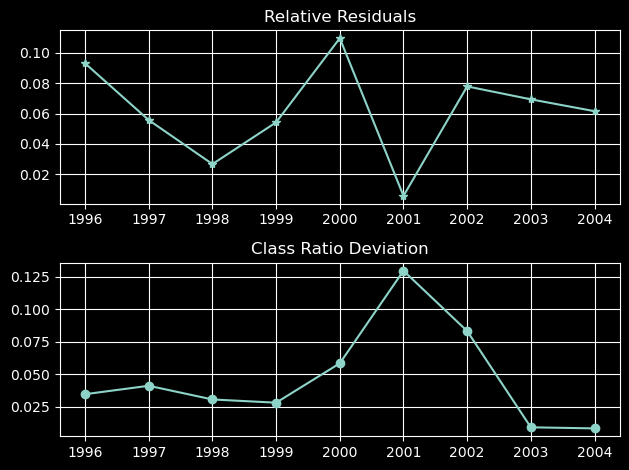

Average relative residual: 0.06
Good fitting
Average eta: 0.05
Good fitting


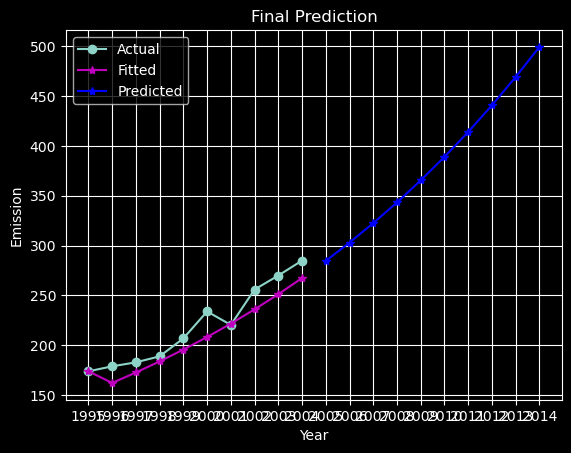

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 GM(1,1) 模型函数
def gm11(x0, predict_num):
    """
    GM(1,1) 模型实现函数
    :param x0: 原始数据序列
    :param predict_num: 预测期数
    :return: 预测结果、拟合值、相对残差、级比偏差
    """
    n = len(x0)  # 数据长度
    x1 = np.cumsum(x0)  # 一次累加生成序列
    z1 = (x1[:-1] + x1[1:]) / 2.0  # 中间值序列

    y = x0[1:]  # 原始数据的后n-1项
    x = z1  # 中间值序列

    # 使用最小二乘法求解参数
    k = ((n-1)*np.sum(x*y) - np.sum(x)*np.sum(y)) / ((n-1)*np.sum(x*x) - np.sum(x)**2)
    b = (np.sum(x*x)*np.sum(y) - np.sum(x)*np.sum(x*y)) / ((n-1)*np.sum(x*x) - np.sum(x)**2)
    a = -k  # 参数a

    # 拟合值计算
    x0_hat = np.zeros(n)
    x0_hat[0] = x0[0]  # 第一个值为原始数据
    for m in range(1, n):
        x0_hat[m] = (1 - np.exp(a)) * (x0[0] - b/a) * np.exp(-a*(m-1))

    # 预测值计算
    result = np.zeros(predict_num)
    for i in range(predict_num):
        result[i] = (1 - np.exp(a)) * (x0[0] - b/a) * np.exp(-a*(n + i -1))

    # 计算残差和级比偏差
    absolute_residuals = x0[1:] - x0_hat[1:]  # 绝对残差
    relative_residuals = np.abs(absolute_residuals) / x0[1:]  # 相对残差

    class_ratio = x0[1:] / x0[:-1]  # 级比
    eta = np.abs(1 - (1-0.5*a)/(1+0.5*a) * (1/class_ratio))  # 级比偏差

    return result, x0_hat, relative_residuals, eta


def main():
    """
    主函数，用于数据处理、模型训练、预测和结果展示
    """
    # 输入数据
    year = np.arange(1995, 2005).reshape(-1, 1)  # 年份
    x0 = np.array([174, 179, 183, 189, 207, 234, 220.5, 256, 270, 285]).reshape(-1, 1)  # 原始数据

    # 绘制原始数据图
    plt.figure(1)
    plt.plot(year, x0, 'o-')
    plt.grid(True)
    plt.xticks(year.flatten())
    plt.xlabel('Year')
    plt.ylabel('Emission')
    plt.title('Original Data')
    plt.show()

    # 错误检查
    ERROR = 0  # 错误标志
    if np.sum(x0 < 0) > 0:
        print("Data contains negative values!")  # 检查数据是否包含负值
        ERROR = 1
    
    n = len(x0)
    print(f"Data length: {n}")
    if n <= 3:
        print("Insufficient data!")  # 数据长度小于等于3时，数据不足
        ERROR = 1
    
    if n > 10:
        print("Consider other methods for large datasets")  # 数据长度大于10时，建议使用其他方法

    # 准指数检验
    if ERROR == 0:
        x1 = np.cumsum(x0)  # 一次累加生成序列
        rho = x0[1:] / x1[:-1]  # 准指数检验的平滑比
        
        plt.figure(2)
        plt.plot(year[1:], rho, 'o-')
        plt.plot([year[1], year[-1]], [0.5, 0.5], '-')  # 绘制平滑比与0.5的对比线
        plt.grid(True)
        plt.xticks(year[1:].flatten())
        plt.xlabel('Year')
        plt.ylabel('Smoothness Ratio')
        plt.title('Quasi-Exponential Test')
        plt.show()

        print(f"Smooth ratio <0.5: {100*np.sum(rho<0.5)/(n-1):.1f}%")  # 计算平滑比小于0.5的比例
        print(f"Excluding first two: {100*np.sum(rho[2:]<0.5)/(n-3):.1f}%")  # 排除前两个数据后的比例
        
        judge = int(input("Pass quasi-exponential test? (1/0): "))  # 用户判断是否通过准指数检验
        if judge == 0:
            ERROR = 1
    
    if ERROR == 0:
        test_num = 3 if n >7 else 2  # 根据数据长度确定测试数据的数量
        train_x0 = x0[:-test_num]  # 训练数据
        test_x0 = x0[-test_num:]  # 测试数据
        
        print(f"Training data: {train_x0.flatten()}")
        print(f"Test data: {test_x0.flatten()}")

        # 模型训练和预测
        result1, _, _, _ = gm11(train_x0.flatten(), test_num)
        
        # 绘制测试结果
        test_years = year[-test_num:]
        plt.figure(3)
        plt.plot(test_years, test_x0, 'o-', label='Actual')
        plt.plot(test_years, result1, '*-', label='Predicted')
        plt.grid(True)
        plt.xticks(test_years.flatten())
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel('Emission')
        plt.title('GM(1,1) Prediction')
        plt.show()

        predict_num = int(input("Enter prediction periods: "))  # 输入预测期数
        final_result, x0_hat, rel_res, eta = gm11(x0.flatten(), predict_num)

        # 输出结果
        print("\nFitting results:")
        for i in range(n):
            print(f"{year[i][0]}: {x0_hat[i]:.1f}")
        
        print("\nPredictions:")
        for i in range(predict_num):
            print(f"{year[-1][0]+i+1}: {final_result[i]:.1f}")

        # 绘制残差和级比偏差
        plt.figure(4)
        plt.subplot(2,1,1)
        plt.plot(year[1:], rel_res, '*-')
        plt.grid(True)
        plt.title('Relative Residuals')
        
        plt.subplot(2,1,2)
        plt.plot(year[1:], eta, 'o-')
        plt.grid(True)
        plt.title('Class Ratio Deviation')
        plt.tight_layout()
        plt.show()

        # 模型评估
        avg_rel = np.mean(rel_res)  # 平均相对残差
        print(f"Average relative residual: {avg_rel:.2f}")
        if avg_rel < 0.1:
            print("Good fitting")
        elif avg_rel <0.2:
            print("Moderate fitting")
        else:
            print("Poor fitting")
        
        avg_eta = np.mean(eta)  # 平均级比偏差
        print(f"Average eta: {avg_eta:.2f}")
        if avg_eta <0.1:
            print("Good fitting")
        elif avg_eta <0.2:
            print("Moderate fitting")
        else:
            print("Poor fitting")

        # 最终预测图
        pred_years = np.arange(year[-1][0]+1, year[-1][0]+predict_num+1)  # 预测年份
        plt.figure(5)
        plt.plot(year, x0, 'o-', label='Actual')
        plt.plot(year, x0_hat, '*-m', label='Fitted')
        plt.plot(pred_years, final_result, '*-b', label='Predicted')
        plt.grid(True)
        plt.xticks(np.arange(year[0][0], year[-1][0]+predict_num+1))
        plt.legend()
        plt.xlabel('Year')
        plt.ylabel('Emission')
        plt.title('Final Prediction')
        plt.show()

if __name__ == "__main__":  # 主函数入口
    main()  # 调用主函数